9,16,25,29,41,74,96

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import lpips
from clip import clip
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def get_optimal_win_size(max_size, min_dim):
    """
    Returns the largest odd win_size <= min(max_size, min_dim).
    """
    for ws in range(min(max_size, min_dim), 2, -1):
        if ws % 2 == 1:
            return ws
    return None

def calculate_metrics(hr_dir, models_dirs, device):
    results = []

    # LPIPS setup and move to device
    lpips_fn = lpips.LPIPS(net='alex').to(device)

    # CLIPIQA setup and move to device
    clip_model, preprocess = clip.load("ViT-B/32", device=device)

    for model_name, model_dir in models_dirs.items():
        model_psnr = []
        model_ssim = []
        model_lpips = []
        model_clip = []

        for img_name in os.listdir(model_dir):
            hr_img_path = os.path.join(hr_dir, img_name)
            gen_img_path = os.path.join(model_dir, img_name)

            if not os.path.exists(hr_img_path):
                print(f"HR image not found for {img_name}, skipping.")
                continue

            # Load images
            hr_img = np.array(Image.open(hr_img_path).convert('RGB'))
            gen_img = np.array(Image.open(gen_img_path).convert('RGB'))
            # print(f"HR Image Dimensions: {hr_img.shape}, Generated Image Dimensions: {gen_img.shape}")

            if hr_img.shape != gen_img.shape:
                # print(f"Dimension mismatch: HR: {hr_img.shape}, Generated: {gen_img.shape}")
                common_height = min(hr_img.shape[0], gen_img.shape[0])
                common_width = min(hr_img.shape[1], gen_img.shape[1])

                # Crop both images
                hr_img = hr_img[:common_height, :common_width, :]
                gen_img = gen_img[:common_height, :common_width, :]

            # Calculate PSNR
            psnr_value = psnr(hr_img, gen_img)
            model_psnr.append(psnr_value)

            # Calculate SSIM
            min_dim = min(hr_img.shape[0], hr_img.shape[1])
            win_size = get_optimal_win_size(7, min_dim)
            if win_size is None:
                print(f"Skipping SSIM for {img_name}: Images too small for SSIM calculation.")
                continue  # Skip SSIM calculation for this image pair

            # Calculate SSIM with the determined win_size
            try:
                ssim_value = ssim(hr_img, gen_img, channel_axis=-1, win_size=win_size)
                model_ssim.append(ssim_value)
            except ValueError as ve:
                print(f"SSIM calculation failed for {img_name}: {ve}")
                continue

            # Calculate LPIPS
            hr_tensor = transforms.ToTensor()(Image.open(hr_img_path).convert('RGB')).unsqueeze(0).to(device)
            gen_tensor = transforms.ToTensor()(Image.open(gen_img_path).convert('RGB')).unsqueeze(0).to(device)
            lpips_score = lpips_fn(hr_tensor, gen_tensor).item()
            model_lpips.append(lpips_score)

            # Calculate CLIPIQA
            hr_clip_input = preprocess(Image.open(hr_img_path).convert('RGB')).unsqueeze(0).to(device)
            gen_clip_input = preprocess(Image.open(gen_img_path).convert('RGB')).unsqueeze(0).to(device)
            with torch.no_grad():
                hr_features = clip_model.encode_image(hr_clip_input)
                gen_features = clip_model.encode_image(gen_clip_input)
            similarity = torch.cosine_similarity(hr_features, gen_features)
            model_clip.append(similarity.item())
            print(f"Model Name: {model_name}, Image: {img_name}, PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}, LPIPS: {lpips_score:.2f}, CLIPIQA: {similarity.item():.2f}")

        # Ensure that all metric lists have entries before computing means
        if model_psnr and model_ssim and model_lpips and model_clip:
            results.append({
                "Model": model_name,
                "PSNR": np.mean(model_psnr),
                "SSIM": np.mean(model_ssim),
                "LPIPS": np.mean(model_lpips),
                "CLIPIQA": np.mean(model_clip),
            })
        else:
            print(f"No valid metrics calculated for model {model_name}.")

    return results

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Directories
hr_dir = "dataset/DIV/final/high"
models_dirs = {
    "BSRGAN": "flask/static/images/selected_256_BSRGAN",
    "RealESRGAN": "flask/static/images/selected_256_RealESRGAN",
    "ResShift": "flask/static/images/selected_256_ResShift",
    "SwinIR": "flask/static/images/selected_256_SwinIR",
}

# Calculate metrics
metrics = calculate_metrics(hr_dir, models_dirs, device)

# Convert to DataFrame
df = pd.DataFrame(metrics)


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Model Name: BSRGAN, Image: 0837.png, PSNR: 21.53, SSIM: 0.65, LPIPS: 0.20, CLIPIQA: 0.97
Model Name: BSRGAN, Image: 0896.png, PSNR: 29.88, SSIM: 0.92, LPIPS: 0.08, CLIPIQA: 0.98
Model Name: BSRGAN, Image: 0834.png, PSNR: 23.54, SSIM: 0.70, LPIPS: 0.17, CLIPIQA: 0.97
Model Name: BSRGAN, Image: 0874.png, PSNR: 26.68, SSIM: 0.67, LPIPS: 0.17, CLIPIQA: 0.97
Model Name: BSRGAN, Image: 0819.png, PSNR: 22.92, SSIM: 0.58, LPIPS: 0.22, CLIPIQA: 0.96
Model Name: BSRGAN, Image: 0801.png, PSNR: 23.37, SSIM: 0.62, LPIPS: 0.25, CLIPIQA: 0.98
Model Name: BSRGAN, Image: 0873.png, PSNR: 21.34, SSIM: 0.59, LPIPS: 0.24, CLIPIQA: 0.99
Model Name: BSRGAN, Image: 0821.png, PSNR: 22.58, SSIM: 0.79, LPIPS: 0.10, CLIPIQA: 0.99
Model Name: BSRGAN, Image: 0858.png, PSNR: 24.55, SSIM: 0.57, LPIPS: 0.22, CLIPIQA: 0.9

In [3]:

# Add summary row if DataFrame is not empty
if not df.empty:
    summary = {
        "Model": "Summary",
        "PSNR": df['PSNR'].mean(),
        "SSIM": df['SSIM'].mean(),
        "LPIPS": df['LPIPS'].mean(),
        "CLIPIQA": df['CLIPIQA'].mean(),
    }
    
    # Convert summary to a DataFrame
    summary_df = pd.DataFrame([summary])
    
    # Concatenate the summary row to the original DataFrame
    df = pd.concat([df, summary_df], ignore_index=True)
    
    # Save and display results
    output_path = "metrics_comparison.csv"
    df.to_csv(output_path, index=False)
    print(df)
else:
    print("No metrics to display.")

#        Model       PSNR      SSIM     LPIPS   CLIPIQA
# 0      BSRGAN  23.373336  0.684897  0.183786  0.975122
# 1  RealESRGAN  22.792739  0.675517  0.184462  0.971118
# 2    ResShift  23.871115  0.710454  0.141342  0.988574
# 3      SwinIR  22.752948  0.684922  0.175680  0.966064
# 4     Summary  23.197534  0.688948  0.171318  0.975220


        Model       PSNR      SSIM     LPIPS   CLIPIQA
0      BSRGAN  24.354329  0.703160  0.172492  0.976758
1  RealESRGAN  23.734273  0.696548  0.168849  0.971777
2    ResShift  24.652847  0.723451  0.136435  0.986149
3      SwinIR  23.853267  0.705486  0.163606  0.968001
4     Summary  24.148679  0.707161  0.160345  0.975671


/tmp/ipykernel_1590368/1038712677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[i], x='Model', y=metric, data=df, palette="pastel")
/tmp/ipykernel_1590368/1038712677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[i], x='Model', y=metric, data=df, palette="pastel")
/tmp/ipykernel_1590368/1038712677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[i], x='Model', y=metric, data=df, palette="pastel")
/tmp/ipykernel_1590368/1038712677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is dep

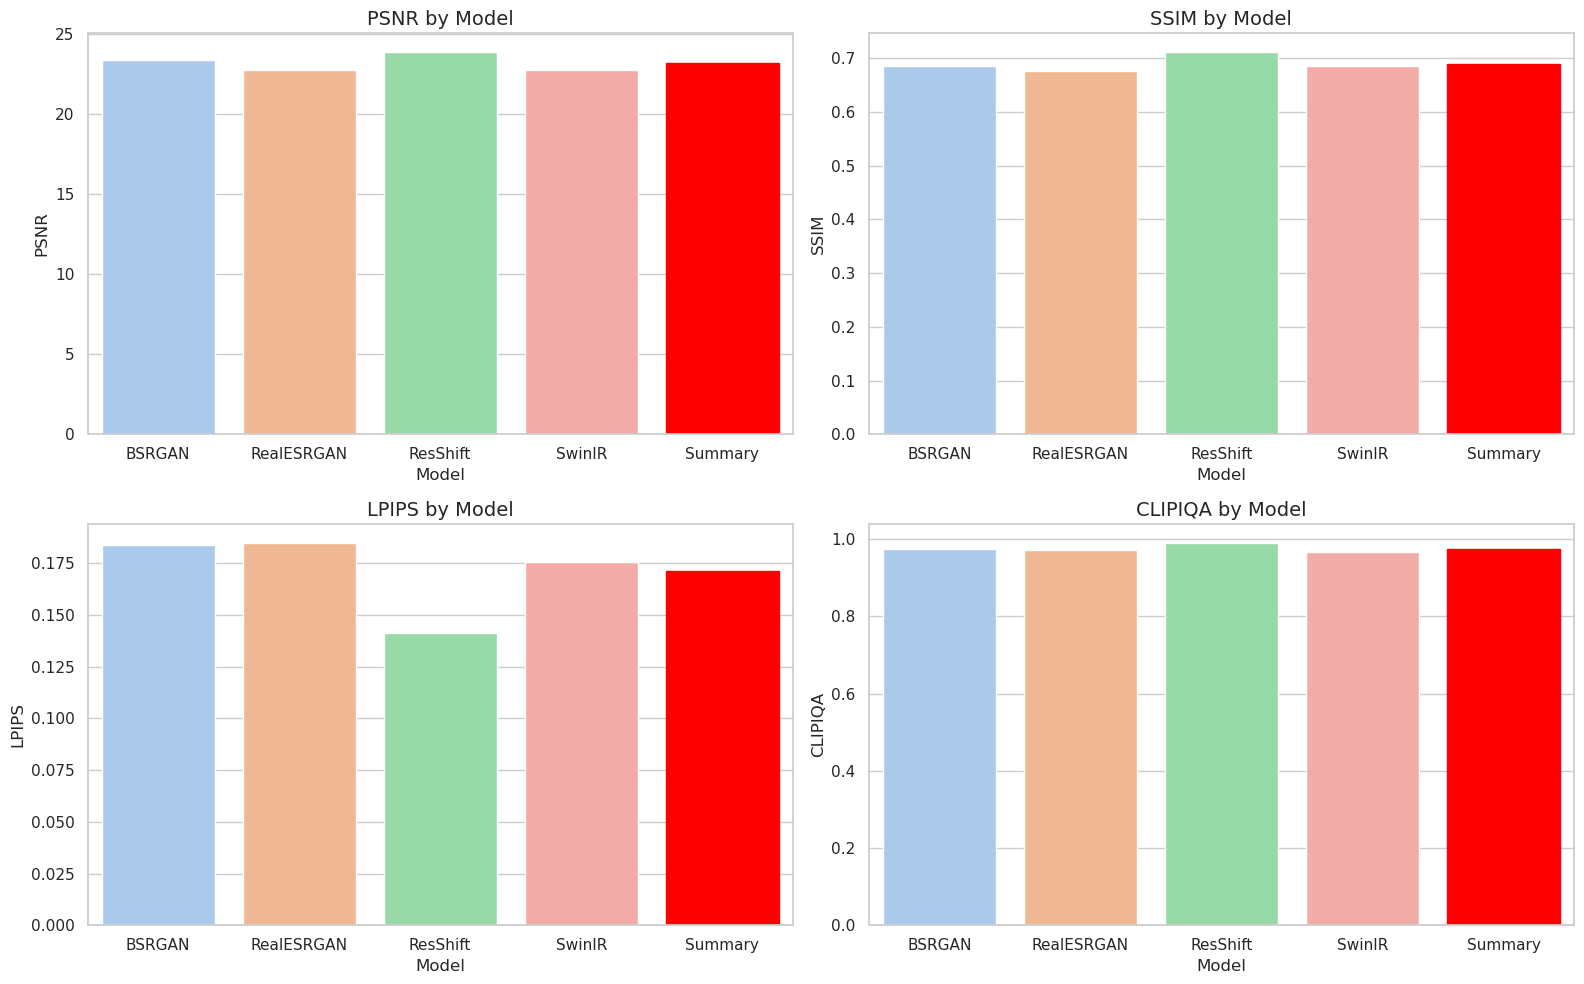

In [20]:
def visualize_metrics_separately(df):
    sns.set(style="whitegrid")
    metrics = ['PSNR', 'SSIM', 'LPIPS', 'CLIPIQA']
    
    # Define the number of plots and layout
    num_metrics = len(metrics)
    cols = 2
    rows = (num_metrics + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        sns.barplot(ax=axes[i], x='Model', y=metric, data=df, palette="pastel")
        axes[i].set_title(f'{metric} by Model', fontsize=14)
        axes[i].set_xlabel('Model', fontsize=12)
        axes[i].set_ylabel(metric, fontsize=12)
        
        # Highlight the Summary row
        for bar, model in zip(axes[i].patches, df['Model']):
            if model == 'Summary':
                bar.set_color('red')
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the alternative visualization function
visualize_metrics_separately(df)


In [5]:
import os
import numpy as np
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import lpips
from clip import clip
from torchvision import transforms
from PIL import Image
import shutil
import matplotlib.pyplot as plt

def get_optimal_win_size(max_size, min_dim):
    """
    Returns the largest odd win_size <= min(max_size, min_dim).
    """
    for ws in range(min(max_size, min_dim), 2, -1):
        if ws % 2 == 1:
            return ws
    return None

def categorize_psnr(psnr_value, good_threshold=20.0, neutral_threshold=18.0):
    """
    Categorize the PSNR value into Good, Neutral, or Bad.
    """
    if psnr_value >= good_threshold:
        return "Good"
    elif psnr_value >= neutral_threshold:
        return "Neutral"
    else:
        return "Bad"

def calculate_and_categorize_metrics(hr_dir, models_dirs, device, 
                                     good_threshold=20.0, neutral_threshold=18.0,
                                     save_csv=True, categorize_images=True):
    """
    Calculates metrics for each image, categorizes them based on PSNR, and counts the categories.
    
    Parameters:
    - hr_dir: Directory containing high-resolution (ground truth) images.
    - models_dirs: Dictionary mapping model names to their respective generated image directories.
    - device: Torch device ('cuda' or 'cpu').
    - good_threshold: PSNR value to classify an image as 'Good'.
    - neutral_threshold: PSNR value to classify an image as 'Neutral'.
    - save_csv: Boolean indicating whether to save the metrics to a CSV file.
    - categorize_images: Boolean indicating whether to categorize and move images.
    
    Returns:
    - df: Pandas DataFrame containing per-image metrics and categories.
    - category_counts: Pandas Series containing counts of each category.
    """
    # Initialize list to store per-image metrics
    per_image_results = []
    
    # Initialize LPIPS and CLIP models
    lpips_fn = lpips.LPIPS(net='alex').to(device)
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    
    # Define transforms
    to_tensor = transforms.ToTensor()
    
    for model_name, model_dir in models_dirs.items():
        print(f"\nProcessing model: {model_name}")
        for img_name in os.listdir(model_dir):
            hr_img_path = os.path.join(hr_dir, img_name)
            gen_img_path = os.path.join(model_dir, img_name)
    
            if not os.path.exists(hr_img_path):
                print(f"HR image not found for {img_name}, skipping.")
                continue
    
            # Load images
            try:
                hr_img = np.array(Image.open(hr_img_path).convert('RGB'))
                gen_img = np.array(Image.open(gen_img_path).convert('RGB'))
            except Exception as e:
                print(f"Error loading images for {img_name}: {e}")
                continue
    
            if hr_img.shape != gen_img.shape:
                print(f"Dimension mismatch for {img_name}: HR {hr_img.shape}, Gen {gen_img.shape}. Cropping to common size.")
                common_height = min(hr_img.shape[0], gen_img.shape[0])
                common_width = min(hr_img.shape[1], gen_img.shape[1])
                hr_img = hr_img[:common_height, :common_width, :]
                gen_img = gen_img[:common_height, :common_width, :]
    
            # Calculate PSNR
            psnr_value = psnr(hr_img, gen_img, data_range=gen_img.max() - gen_img.min())
    
            # Calculate SSIM
            min_dim = min(hr_img.shape[0], hr_img.shape[1])
            win_size = get_optimal_win_size(7, min_dim)
            if win_size is None:
                print(f"Skipping SSIM for {img_name}: Images too small for SSIM calculation.")
                ssim_value = np.nan
            else:
                try:
                    ssim_value = ssim(hr_img, gen_img, channel_axis=-1, win_size=win_size)
                except ValueError as ve:
                    print(f"SSIM calculation failed for {img_name}: {ve}")
                    ssim_value = np.nan
    
            # Calculate LPIPS
            try:
                hr_tensor = to_tensor(Image.open(hr_img_path).convert('RGB')).unsqueeze(0).to(device)
                gen_tensor = to_tensor(Image.open(gen_img_path).convert('RGB')).unsqueeze(0).to(device)
                lpips_score = lpips_fn(hr_tensor, gen_tensor).item()
            except Exception as e:
                print(f"LPIPS calculation failed for {img_name}: {e}")
                lpips_score = np.nan
    
            # Calculate CLIPIQA
            try:
                hr_clip_input = preprocess(Image.open(hr_img_path).convert('RGB')).unsqueeze(0).to(device)
                gen_clip_input = preprocess(Image.open(gen_img_path).convert('RGB')).unsqueeze(0).to(device)
                with torch.no_grad():
                    hr_features = clip_model.encode_image(hr_clip_input)
                    gen_features = clip_model.encode_image(gen_clip_input)
                similarity = torch.cosine_similarity(hr_features, gen_features).item()
            except Exception as e:
                print(f"CLIPIQA calculation failed for {img_name}: {e}")
                similarity = np.nan
    
            # Categorize based on PSNR
            category = categorize_psnr(psnr_value, good_threshold, neutral_threshold)
    
            # Append results
            per_image_results.append({
                "Model": model_name,
                "Image_Name": img_name,
                "PSNR": psnr_value,
                "SSIM": ssim_value,
                "LPIPS": lpips_score,
                "CLIPIQA": similarity,
                "Category": category
            })
    
    # Convert results to DataFrame
    df = pd.DataFrame(per_image_results)
    
    # Handle missing values if any
    df.fillna("N/A", inplace=True)
    
    # Save to CSV if required
    if save_csv:
        output_csv = "per_image_metrics_and_categories.csv"
        df.to_csv(output_csv, index=False)
        print(f"\nPer-image metrics and categories saved to {output_csv}")
    
    # Count categories
    category_counts = df['Category'].value_counts()
    print("\nImage Categories Based on PSNR:")
    print(category_counts)
    
    # Optionally, move images to respective folders
    if categorize_images:
        # Define the base directory where generated images are stored
        # Adjust this path if your structure is different
        base_generated_dir = "flask/static/images/"
    
        # Define destination directories
        dest_dirs = {
            "Good": os.path.join(base_generated_dir, "Good"),
            "Neutral": os.path.join(base_generated_dir, "Neutral"),
            "Bad": os.path.join(base_generated_dir, "Bad"),
            "N/A": os.path.join(base_generated_dir, "Uncategorized")  # For any uncategorized or failed cases
        }
    
        # Create destination directories if they don't exist
        for category, path in dest_dirs.items():
            os.makedirs(path, exist_ok=True)
    
        # Function to move images
        def move_image(row):
            model = row['Model']
            img_name = row['Image_Name']
            category = row['Category']
            
            # Define source path
            source_path = os.path.join(base_generated_dir, model, img_name)
            
            # Define destination path
            dest_path = os.path.join(dest_dirs.get(category, dest_dirs["N/A"]), img_name)
            
            # Check if source image exists
            if os.path.exists(source_path):
                try:
                    shutil.move(source_path, dest_path)
                    print(f"Moved {img_name} to {category} folder.")
                except Exception as e:
                    print(f"Error moving {img_name}: {e}")
            else:
                print(f"Source image {source_path} does not exist.")
    
        # Apply the move function to each row
        df.apply(move_image, axis=1)
    
        print("\nImage categorization and moving completed.")
    
    return df, category_counts

def visualize_category_distribution(category_counts, output_path="category_distribution.png"):
    """
    Creates a bar chart for the category distribution.
    
    Parameters:
    - category_counts: Pandas Series containing counts of each category.
    - output_path: Path to save the generated plot.
    """
    category_counts.plot(kind='bar', color=['green', 'orange', 'red', 'grey'])
    plt.title('Image Categories Based on PSNR')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"Category distribution plot saved to {output_path}")

if __name__ == "__main__":
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define directories
    hr_dir = "dataset/DIV/final/high"
    models_dirs = {
        "BSRGAN": "flask/static/images/selected_256_BSRGAN",
        "RealESRGAN": "flask/static/images/selected_256_RealESRGAN",
        "ResShift": "flask/static/images/selected_256_ResShift",
        "SwinIR": "flask/static/images/selected_256_SwinIR",
    }
    
    # Define PSNR thresholds
    GOOD_THRESHOLD = 23.0
    NEUTRAL_THRESHOLD = 21.0
    
    # Calculate and categorize metrics
    df_metrics, counts = calculate_and_categorize_metrics(
        hr_dir=hr_dir,
        models_dirs=models_dirs,
        device=device,
        good_threshold=GOOD_THRESHOLD,
        neutral_threshold=NEUTRAL_THRESHOLD,
        save_csv=True,
        categorize_images=True  # Set to False if you don't want to move images
    )
    

Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, m


Processing model: BSRGAN
Dimension mismatch for 0837.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0896.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0834.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0874.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0819.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0801.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0873.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0821.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0858.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dimension mismatch for 0899.png: HR (678, 1020, 3), Gen (676, 1020, 3). Cropping to common size.
Dime

DataFrame:
         Model       PSNR      SSIM     LPIPS   CLIPIQA
0      BSRGAN  23.373336  0.684897  0.183786  0.975122
1  RealESRGAN  22.792739  0.675517  0.184462  0.971118
2    ResShift  23.871115  0.710454  0.141342  0.988574
3      SwinIR  22.752948  0.684922  0.175680  0.966064

Sorted DataFrame:
         Model       PSNR      SSIM     LPIPS   CLIPIQA
0    ResShift  23.871115  0.710454  0.141342  0.988574
1      BSRGAN  23.373336  0.684897  0.183786  0.975122
2  RealESRGAN  22.792739  0.675517  0.184462  0.971118
3      SwinIR  22.752948  0.684922  0.175680  0.966064


/tmp/ipykernel_1590368/3262207698.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


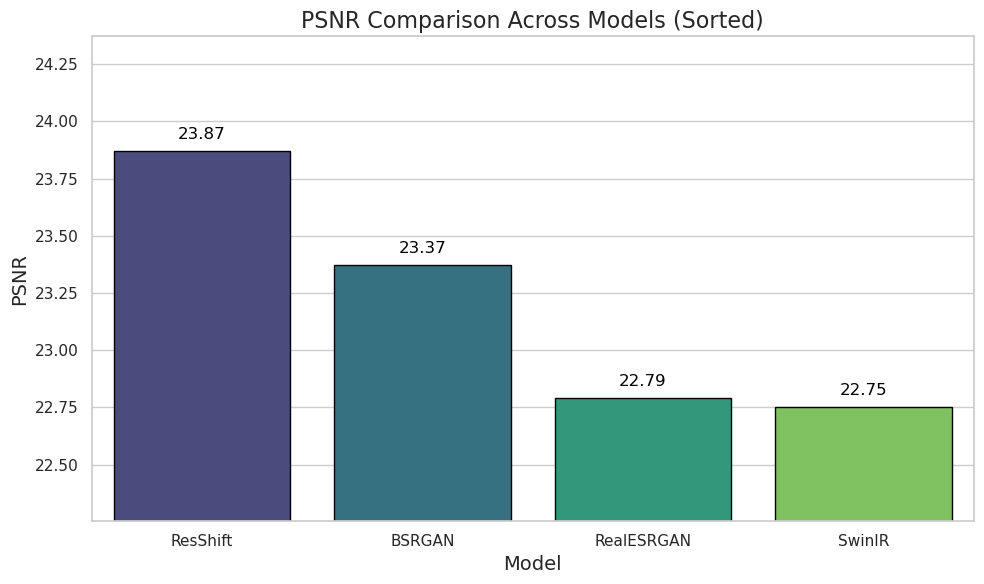

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
data = {
    "Model": ["BSRGAN", "RealESRGAN", "ResShift", "SwinIR"],
    "PSNR": [23.373336, 22.792739, 23.871115, 22.752948],
    # Other metrics can be included if needed
    "SSIM": [0.684897, 0.675517, 0.710454, 0.684922],
    "LPIPS": [0.183786, 0.184462, 0.141342, 0.175680],
    "CLIPIQA": [0.975122, 0.971118, 0.988574, 0.966064]
}

df = pd.DataFrame(data)

# Optional: Save to CSV
output_path = "metrics_comparison_psnr_sorted.csv"
df.to_csv(output_path, index=False)
print("DataFrame:\n", df)

# 2. Sorting the DataFrame by PSNR in Descending Order
df_sorted = df.sort_values(by='PSNR', ascending=False).reset_index(drop=True)
print("\nSorted DataFrame:\n", df_sorted)

# 3. Visualization Function
def visualize_psnr_sorted(df):
    sns.set(style="whitegrid")  # Set the visual style
    
    plt.figure(figsize=(10, 6))  # Initialize the matplotlib figure
    
    # Create the bar plot with sorted data
    bar_plot = sns.barplot(
        x="Model",
        y="PSNR",
        data=df,
        palette="viridis",
        edgecolor='black'
    )
    
    # Titles and labels
    plt.title("PSNR Comparison Across Models (Sorted)", fontsize=16)
    plt.xlabel("Model", fontsize=14)
    plt.ylabel("PSNR", fontsize=14)
    
    # Y-axis limits to emphasize differences
    min_psnr = df['PSNR'].min() - 0.5
    max_psnr = df['PSNR'].max() + 0.5
    plt.ylim(min_psnr, max_psnr)
    
    # Annotate bars with PSNR values
    for index, row in df.iterrows():
        bar_plot.text(
            index,
            row.PSNR + 0.05,  # Slightly above the bar
            f"{row.PSNR:.2f}",
            color='black',
            ha="center",
            fontsize=12
        )
    
    # Enhance layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# 4. Call the Visualization Function with Sorted DataFrame
visualize_psnr_sorted(df_sorted)


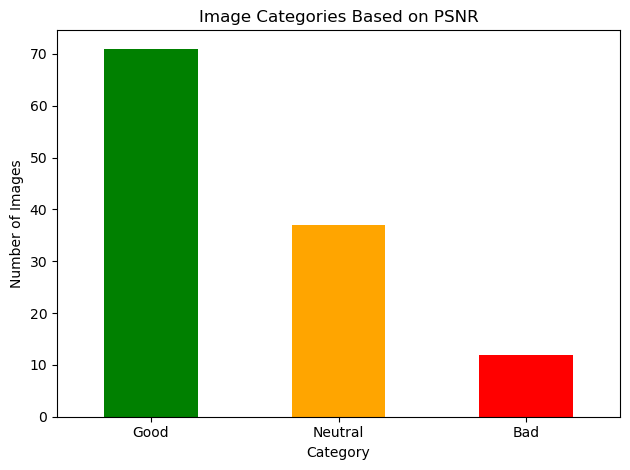

Category distribution plot saved to category_distribution.png


In [6]:

# Visualize category distribution
visualize_category_distribution(counts, output_path="category_distribution.png")


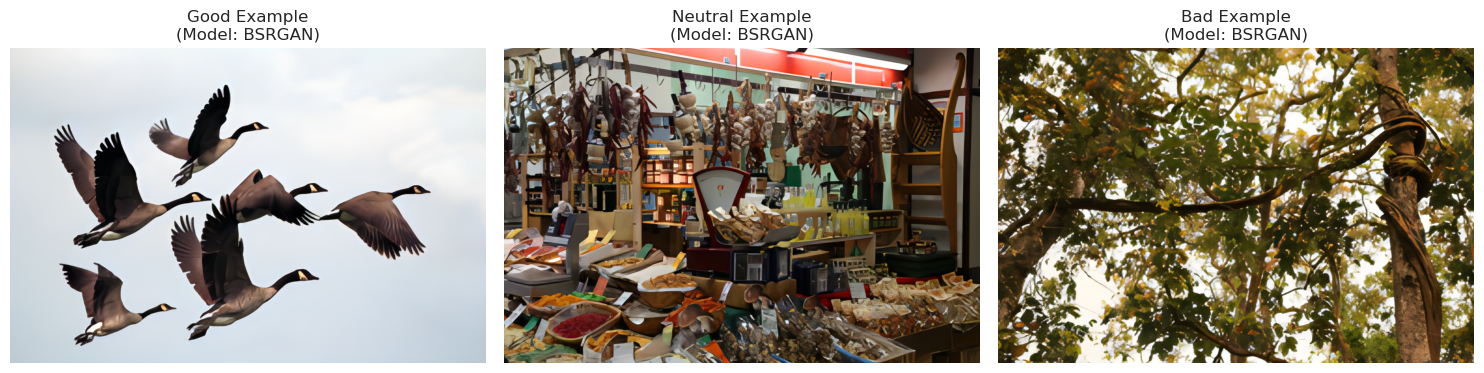

In [17]:
# Block 12: Display Example Images from Each Category

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_example_images(csv_path='per_image_metrics_and_categories.csv', models_dirs=None, categories=["Good", "Neutral", "Bad"]):
    """
    Displays one example image from each specified category.
    
    Parameters:
    - csv_path (str): Path to the CSV file containing image metrics and categories.
    - models_dirs (dict): Dictionary mapping model names to their image directories.
    - categories (list): List of category names to display images from.
    """
    if models_dirs is None:
        models_dirs = {
            "BSRGAN": "flask/static/images/selected_256_BSRGAN",
            "RealESRGAN": "flask/static/images/selected_256_RealESRGAN",
            "ResShift": "flask/static/images/selected_256_ResShift",
            "SwinIR": "flask/static/images/selected_256_SwinIR",
        }
    
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(15,5))
    
    for idx, category in enumerate(categories, 1):
        # Filter the DataFrame for the current category
        category_df = df[df['Category'] == category]
        
        if category_df.empty:
            print(f"No images found in category '{category}'.")
            continue
        
        # Select the first image in the category
        example_row = category_df.iloc[0]
        model_name = example_row['Model']
        img_name = example_row['Image_Name']
        
        # Get the model directory
        model_dir = models_dirs.get(model_name, "")
        if not model_dir:
            print(f"Model directory for '{model_name}' not found.")
            continue
        
        # Construct the image path
        img_path = os.path.join(model_dir, img_name)
        
        if not os.path.exists(img_path):
            print(f"Image path '{img_path}' does not exist.")
            continue
        
        # Open and display the image
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            continue
        
        # Display the image
        plt.subplot(1, 3, idx)
        plt.imshow(img)
        plt.title(f"{category} Example\n(Model: {model_name})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Define models_dirs as per your setup
models_dirs = {
    "BSRGAN": "flask/static/images/selected_256_BSRGAN",
    "RealESRGAN": "flask/static/images/selected_256_RealESRGAN",
    "ResShift": "flask/static/images/selected_256_ResShift",
    "SwinIR": "flask/static/images/selected_256_SwinIR",
}

# Call the function to display example images
display_example_images(csv_path='per_image_metrics_and_categories.csv', models_dirs=models_dirs)


Aggregated category counts saved to aggregated_category_counts.csv


<Figure size 1000x600 with 0 Axes>

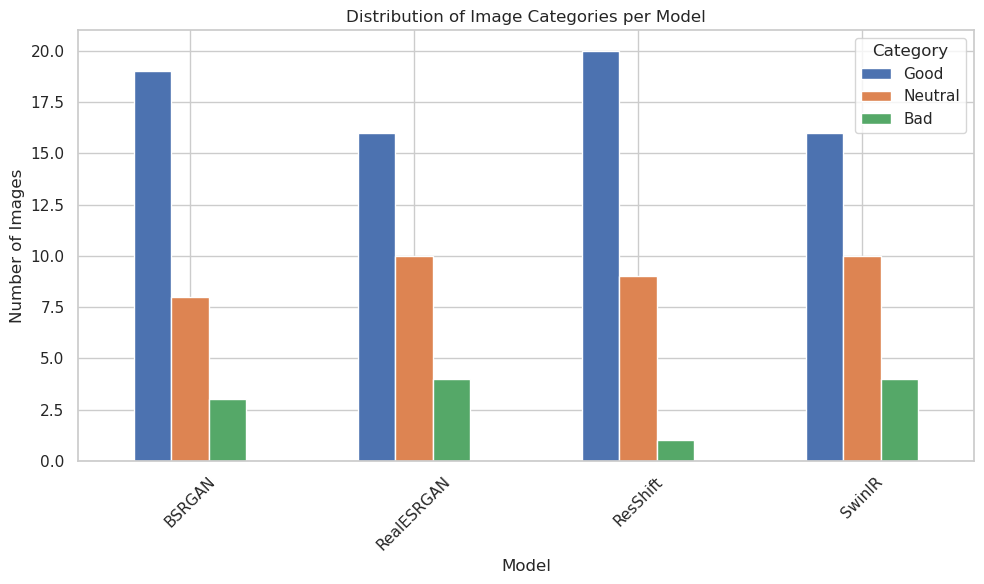

Grouped bar chart saved to visualizations/grouped_bar_chart.png


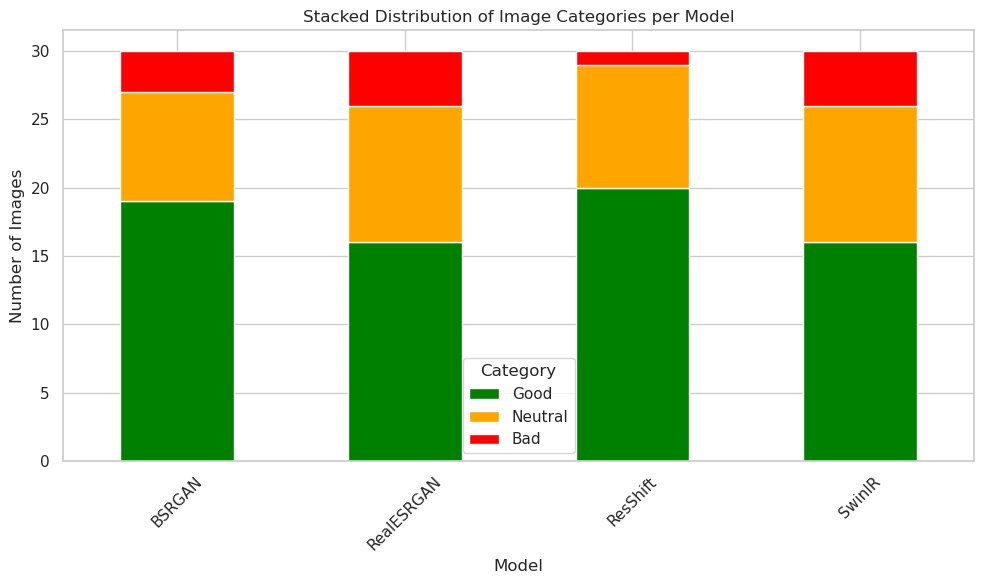

Stacked bar chart saved to visualizations/stacked_bar_chart.png


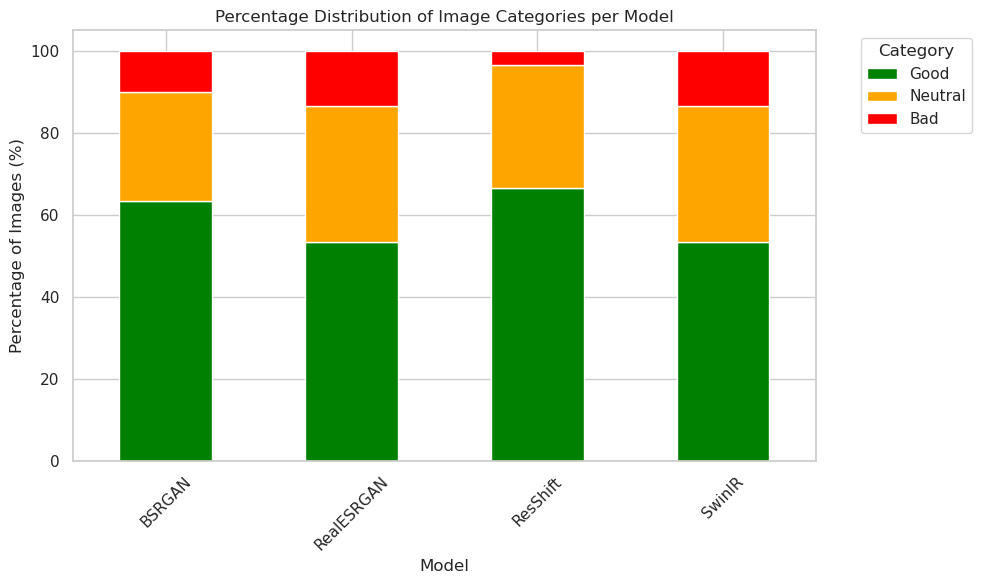

Percentage stacked bar chart saved to visualizations/percentage_stacked_bar_chart.png


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data(csv_path):
    """
    Loads the CSV data into a Pandas DataFrame.

    Parameters:
    - csv_path: Path to the CSV file.

    Returns:
    - df: Pandas DataFrame containing the data.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"The file {csv_path} does not exist.")

    df = pd.read_csv(csv_path)
    return df

def aggregate_category_counts(df):
    """
    Aggregates the count of each category per model.

    Parameters:
    - df: Pandas DataFrame containing per-image metrics and categories.

    Returns:
    - agg_df: Aggregated DataFrame with counts per category per model.
    """
    agg_df = df.groupby(['Model', 'Category']).size().reset_index(name='Count')
    return agg_df

def visualize_distribution(agg_df, output_dir="visualizations"):
    """
    Creates and saves visualizations for the distribution of categories per model.

    Parameters:
    - agg_df: Aggregated DataFrame with counts per category per model.
    - output_dir: Directory where the visualizations will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Pivot the data for easier plotting
    pivot_df = agg_df.pivot(index='Model', columns='Category', values='Count').fillna(0)

    # Reorder the categories for consistent coloring
    categories = ['Good', 'Neutral', 'Bad']
    pivot_df = pivot_df.reindex(columns=categories)

    # Plot 1: Grouped Bar Chart
    plt.figure(figsize=(10, 6))
    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Distribution of Image Categories per Model')
    plt.xlabel('Model')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    grouped_bar_path = os.path.join(output_dir, 'grouped_bar_chart.png')
    plt.savefig(grouped_bar_path)
    plt.show()
    print(f"Grouped bar chart saved to {grouped_bar_path}")

    # Plot 2: Stacked Bar Chart
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'orange', 'red'])
    plt.title('Stacked Distribution of Image Categories per Model')
    plt.xlabel('Model')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    stacked_bar_path = os.path.join(output_dir, 'stacked_bar_chart.png')
    plt.savefig(stacked_bar_path)
    plt.show()
    print(f"Stacked bar chart saved to {stacked_bar_path}")

    # Plot 3: Percentage Stacked Bar Chart
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    pivot_df_percent.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'orange', 'red'])
    plt.title('Percentage Distribution of Image Categories per Model')
    plt.xlabel('Model')
    plt.ylabel('Percentage of Images (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    percentage_bar_path = os.path.join(output_dir, 'percentage_stacked_bar_chart.png')
    plt.savefig(percentage_bar_path)
    plt.show()
    print(f"Percentage stacked bar chart saved to {percentage_bar_path}")

def save_aggregated_data(agg_df, output_csv="aggregated_category_counts.csv"):
    """
    Saves the aggregated category counts to a CSV file.

    Parameters:
    - agg_df: Aggregated DataFrame with counts per category per model.
    - output_csv: Filename for the aggregated CSV.
    """
    agg_df.to_csv(output_csv, index=False)
    print(f"Aggregated category counts saved to {output_csv}")

def main():
    # Define paths
    csv_path = "per_image_metrics_and_categories.csv"
    output_dir = "visualizations"
    aggregated_csv = "aggregated_category_counts.csv"

    # Load data
    df = load_data(csv_path)

    # Aggregate category counts per model
    agg_df = aggregate_category_counts(df)

    # Save aggregated data
    save_aggregated_data(agg_df, output_csv=aggregated_csv)

    # Visualize the distribution
    visualize_distribution(agg_df, output_dir=output_dir)

if __name__ == "__main__":
    main()


count    120.000000
mean      24.137757
std        3.105876
min       17.619624
25%       21.984267
50%       23.784518
75%       26.477212
max       32.276880
Name: PSNR, dtype: float64


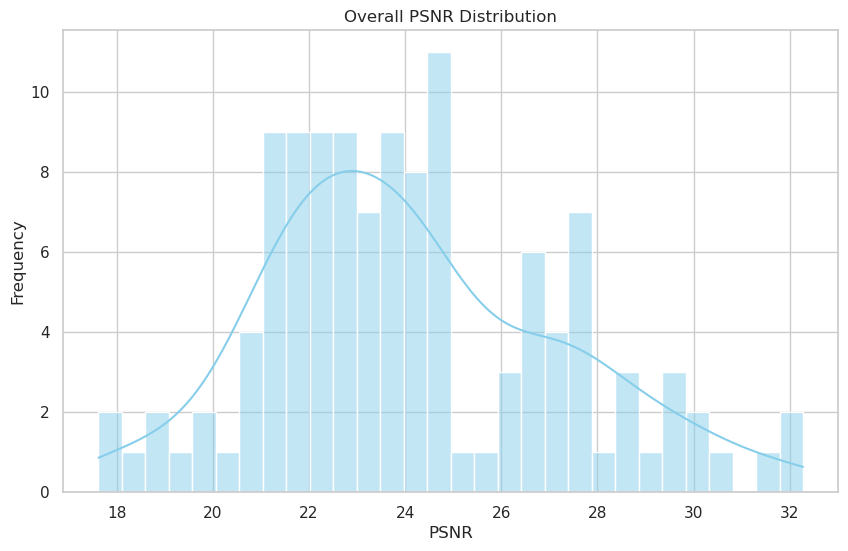

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV data
df = pd.read_csv("per_image_metrics_and_categories.csv")

# Display basic statistics
print(df['PSNR'].describe())

# Check the distribution of PSNR values
plt.figure(figsize=(10, 6))
sns.histplot(df['PSNR'], bins=30, kde=True, color='skyblue')
plt.title('Overall PSNR Distribution')
plt.xlabel('PSNR')
plt.ylabel('Frequency')
plt.show()


In [9]:
# Calculate percentiles
good_threshold = df['PSNR'].quantile(0.75)  # 75th percentile
neutral_threshold = df['PSNR'].quantile(0.50)  # 50th percentile (median)

print(f"Good Threshold (75th percentile): {good_threshold}")
print(f"Neutral Threshold (Median): {neutral_threshold}")


Good Threshold (75th percentile): 26.477211872801643
Neutral Threshold (Median): 23.784518268365538


/tmp/ipykernel_1590368/558088419.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df = pivot_df.replace(category_mapping)


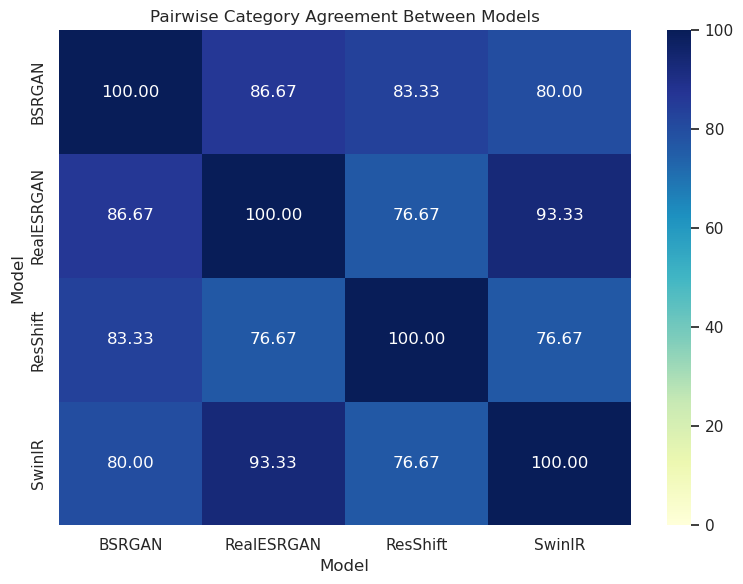

Pairwise agreement heatmap saved to visualizations/pairwise_agreement_heatmap.png


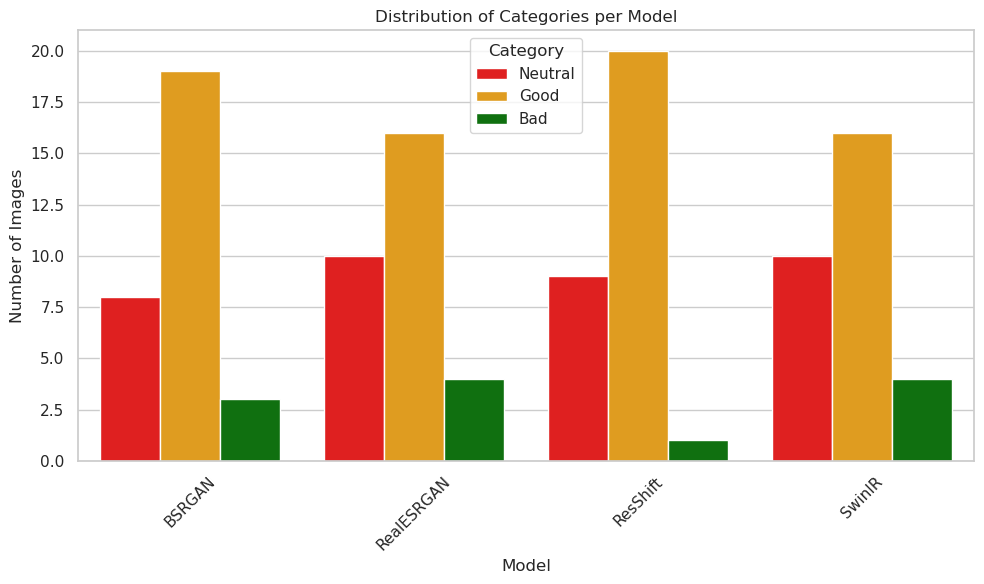

Category distribution per model saved to visualizations/category_distribution_per_model.png


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def load_data(csv_path):
    """
    Load the CSV data into a Pandas DataFrame.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"The file {csv_path} does not exist.")
    
    df = pd.read_csv(csv_path)
    return df

def pivot_data(df):
    """
    Pivot the DataFrame to have Image_Name as index and Models as columns with Category as values.
    """
    pivot_df = df.pivot(index='Image_Name', columns='Model', values='Category')
    return pivot_df

def encode_categories(pivot_df):
    """
    Encode categorical data into numerical values for agreement calculation.
    """
    category_mapping = {'Bad': 0, 'Neutral': 1, 'Good': 2}
    encoded_df = pivot_df.replace(category_mapping)
    return encoded_df, category_mapping

def calculate_pairwise_agreement(encoded_df):
    """
    Calculate the percentage of agreement between each pair of models.
    """
    models = encoded_df.columns
    agreement_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    
    for i in models:
        for j in models:
            if i == j:
                agreement_matrix.loc[i, j] = 100.0
            else:
                total = len(encoded_df)
                agreements = (encoded_df[i] == encoded_df[j]).sum()
                percentage = (agreements / total) * 100
                agreement_matrix.loc[i, j] = percentage
    
    return agreement_matrix

def plot_agreement_heatmap(agreement_matrix, output_path="visualizations"):
    """
    Plot a heatmap of the pairwise agreement percentages between models.
    """
    os.makedirs(output_path, exist_ok=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(agreement_matrix, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=100)
    plt.title('Pairwise Category Agreement Between Models')
    plt.ylabel('Model')
    plt.xlabel('Model')
    plt.tight_layout()
    heatmap_path = os.path.join(output_path, 'pairwise_agreement_heatmap.png')
    plt.savefig(heatmap_path)
    plt.show()
    print(f"Pairwise agreement heatmap saved to {heatmap_path}")

def plot_category_distribution(df, output_path="visualizations"):
    """
    Plot the distribution of categories per model.
    """
    os.makedirs(output_path, exist_ok=True)
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Model', hue='Category', palette=['red', 'orange', 'green'])
    plt.title('Distribution of Categories per Model')
    plt.xlabel('Model')
    plt.ylabel('Number of Images')
    plt.legend(title='Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    distribution_path = os.path.join(output_path, 'category_distribution_per_model.png')
    plt.savefig(distribution_path)
    plt.show()
    print(f"Category distribution per model saved to {distribution_path}")

def main():
    # Define the path to your CSV
    csv_path = "per_image_metrics_and_categories.csv"
    
    # Load data
    df = load_data(csv_path)
    
    # Pivot data
    pivot_df = pivot_data(df)
    
    # Encode categories
    encoded_df, category_mapping = encode_categories(pivot_df)
    
    # Calculate pairwise agreement
    agreement_matrix = calculate_pairwise_agreement(encoded_df)
    
    # Plot agreement heatmap
    plot_agreement_heatmap(agreement_matrix)
    
    # (Optional) Plot category distribution per model
    plot_category_distribution(df)

if __name__ == "__main__":
    main()


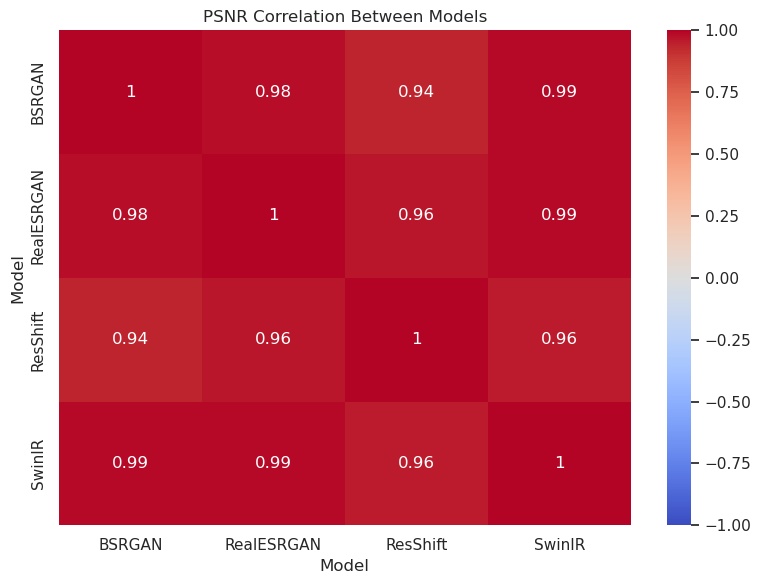

PSNR correlation heatmap saved to visualizations/PSNR_correlation_heatmap.png


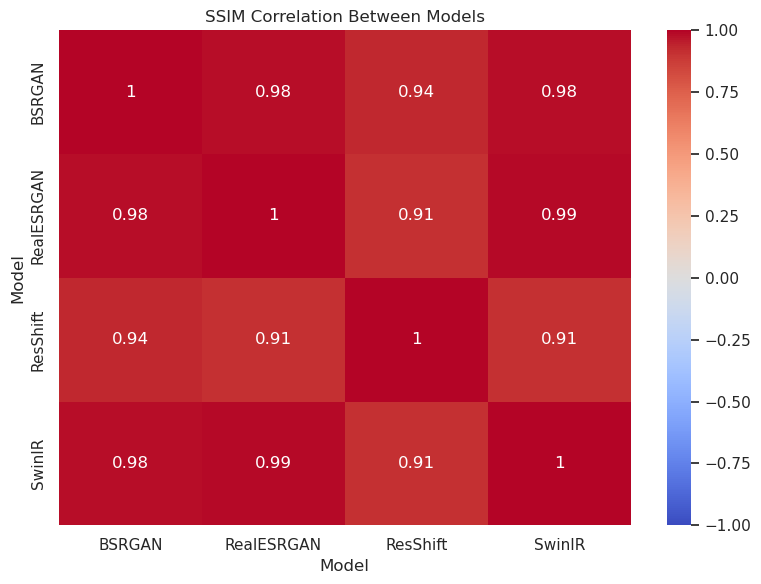

SSIM correlation heatmap saved to visualizations/SSIM_correlation_heatmap.png


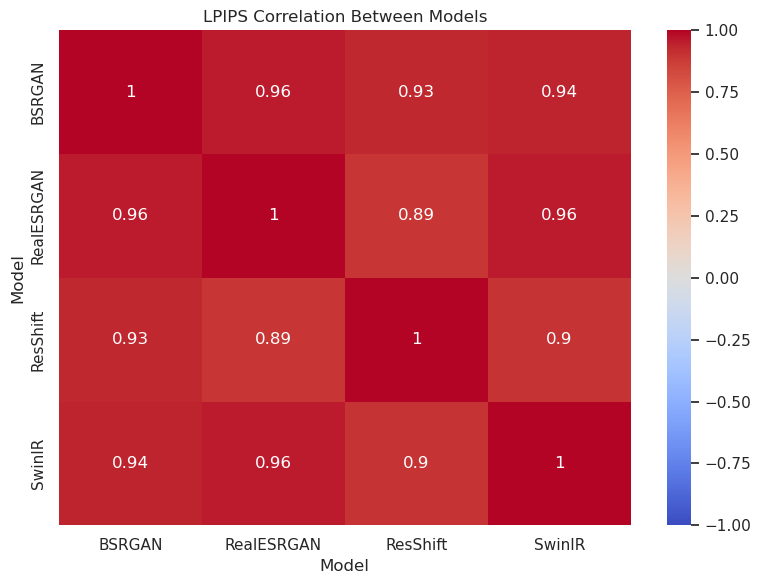

LPIPS correlation heatmap saved to visualizations/LPIPS_correlation_heatmap.png


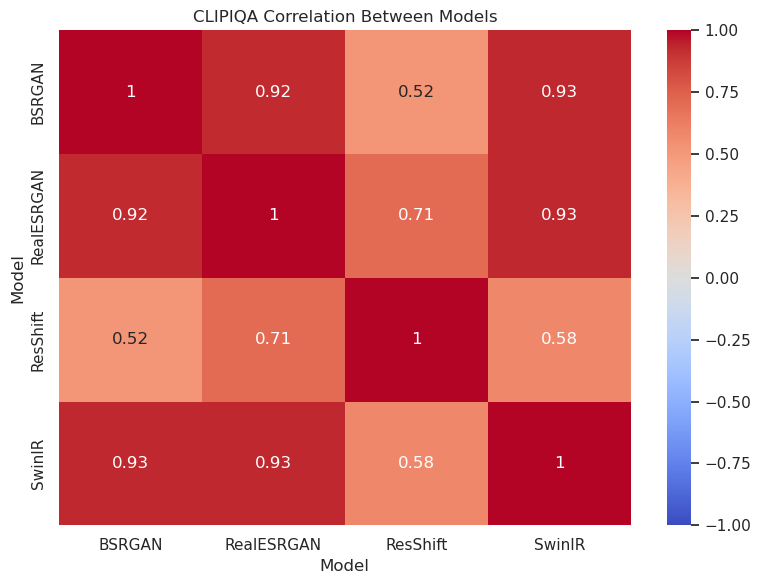

CLIPIQA correlation heatmap saved to visualizations/CLIPIQA_correlation_heatmap.png


In [11]:
def plot_metric_correlation(df, output_path="visualizations"):
    """
    Plot the correlation matrix for different metrics across models.
    """
    # Pivot the DataFrame to have Models as columns and Metrics as rows
    metrics = ['PSNR', 'SSIM', 'LPIPS', 'CLIPIQA']
    pivot_metrics = df.pivot_table(index='Image_Name', columns='Model', values=metrics)
    
    # Calculate correlation between models for each metric
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_metrics[metric].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f'{metric} Correlation Between Models')
        plt.tight_layout()
        metric_corr_path = os.path.join(output_path, f'{metric}_correlation_heatmap.png')
        plt.savefig(metric_corr_path)
        plt.show()
        print(f"{metric} correlation heatmap saved to {metric_corr_path}")

# After other visualizations
plot_metric_correlation(df)


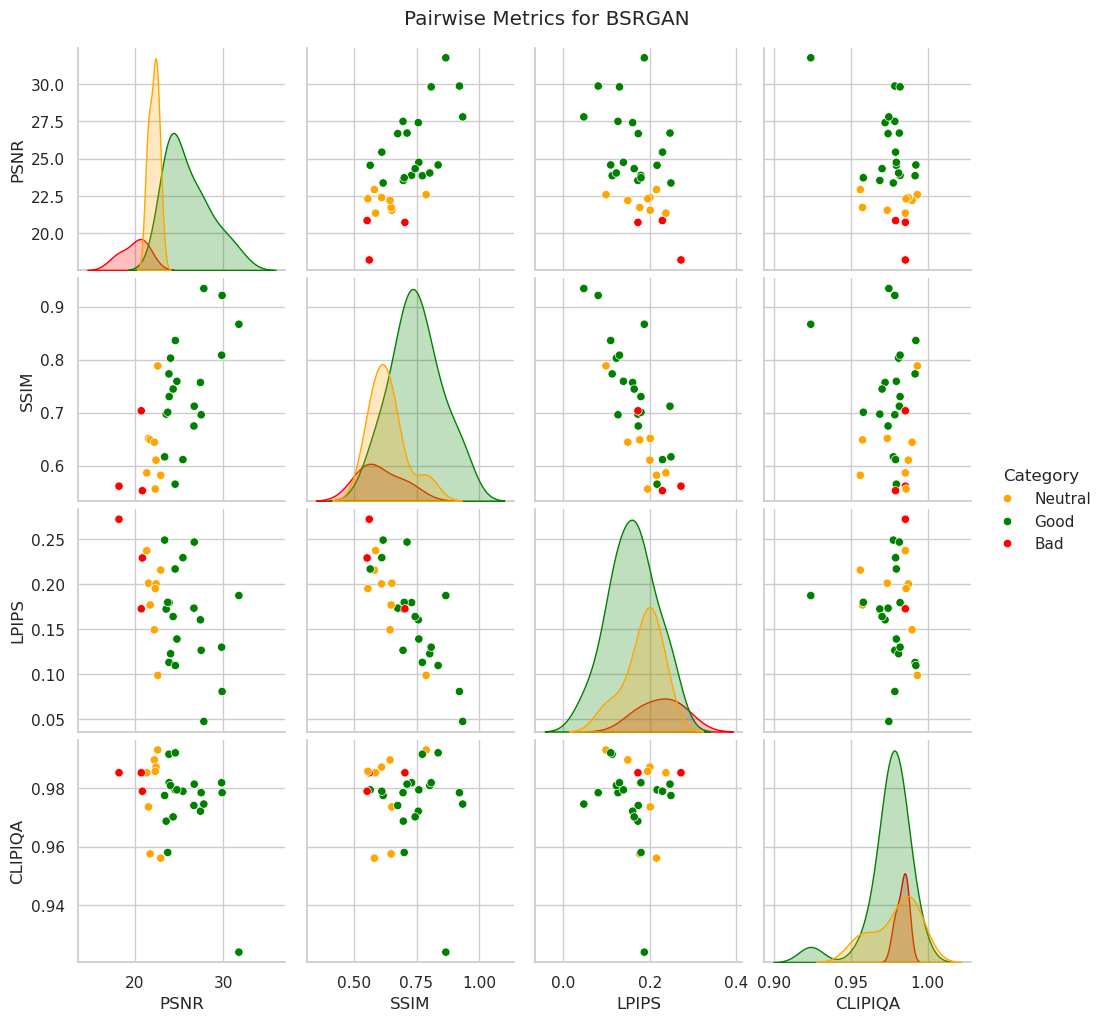

Pairwise metrics plot for BSRGAN saved to visualizations/BSRGAN_pairwise_metrics.png


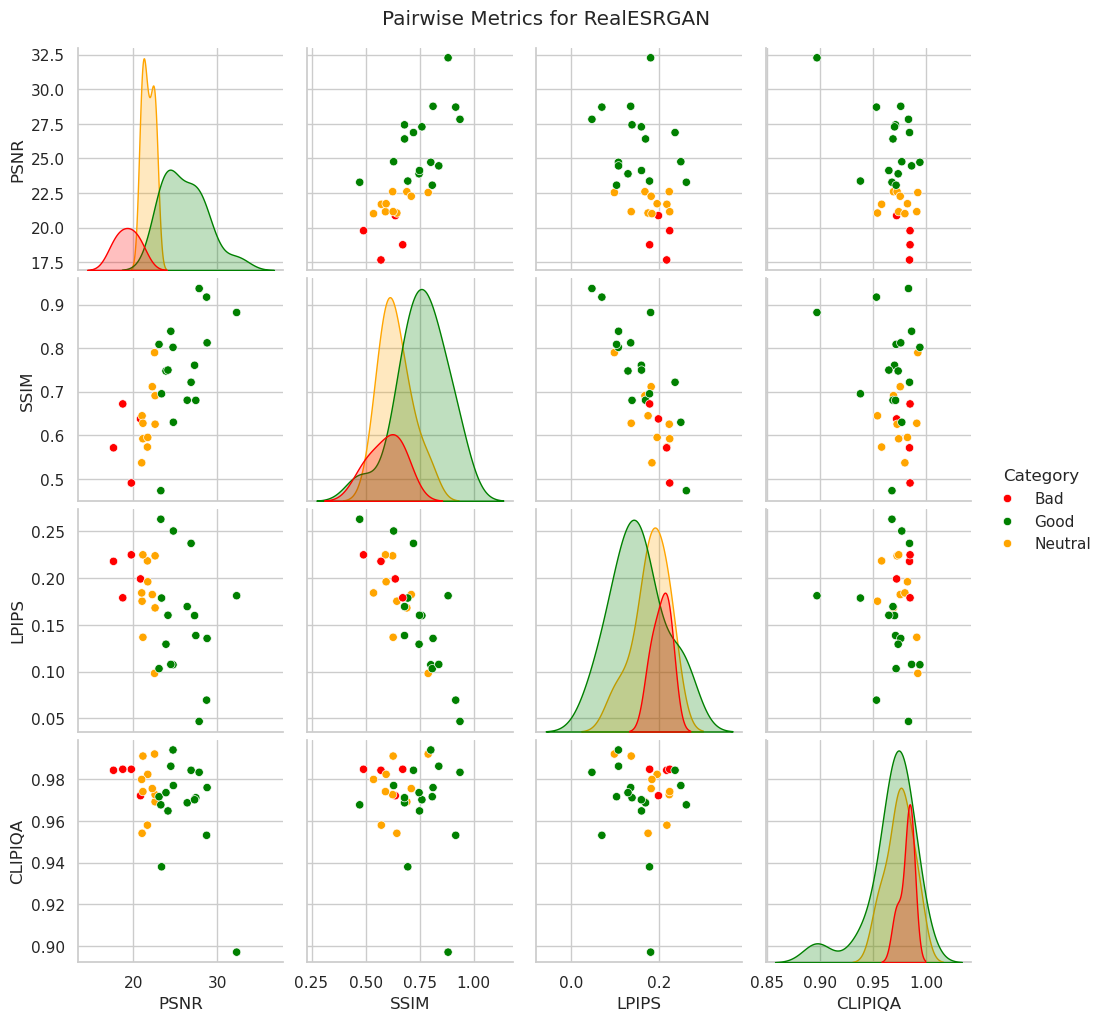

Pairwise metrics plot for RealESRGAN saved to visualizations/RealESRGAN_pairwise_metrics.png


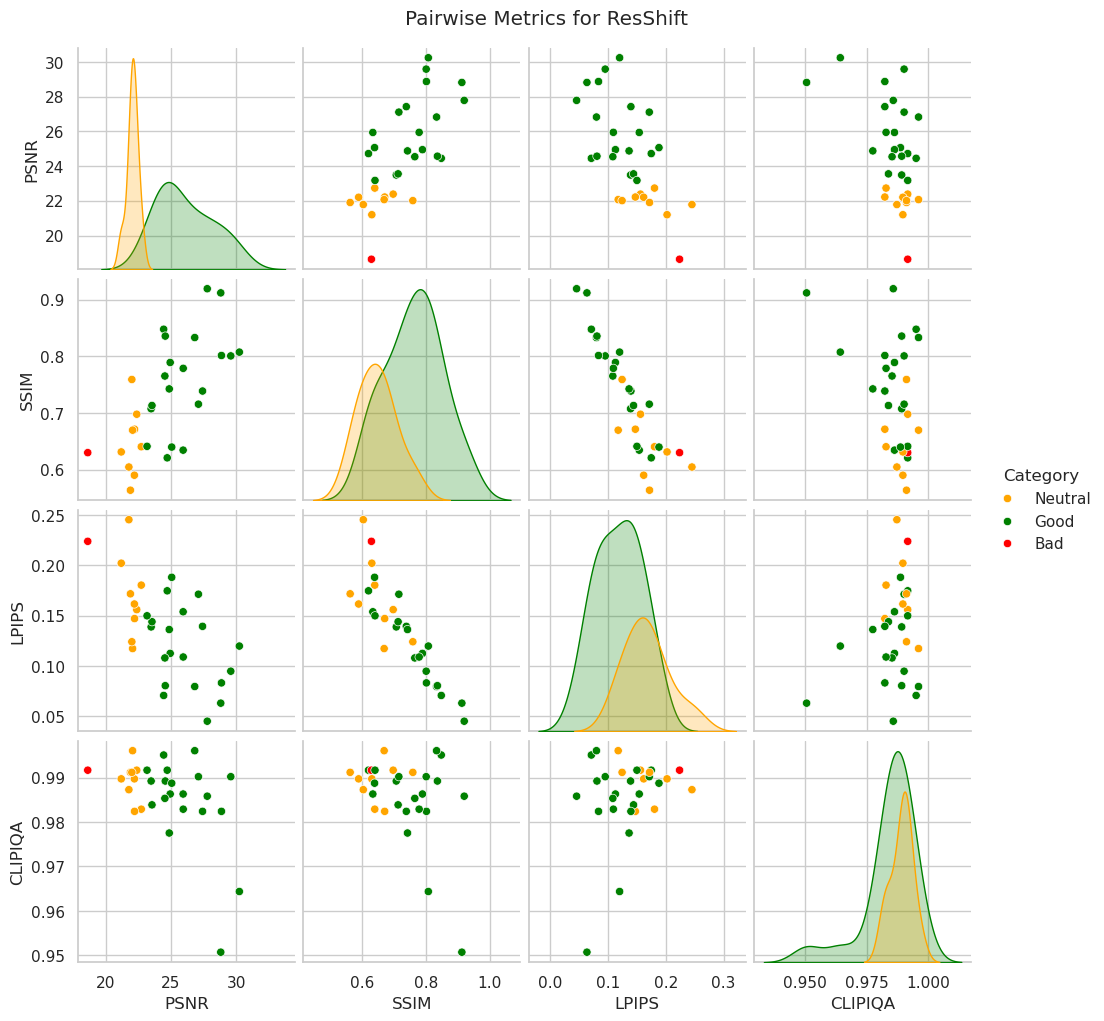

Pairwise metrics plot for ResShift saved to visualizations/ResShift_pairwise_metrics.png


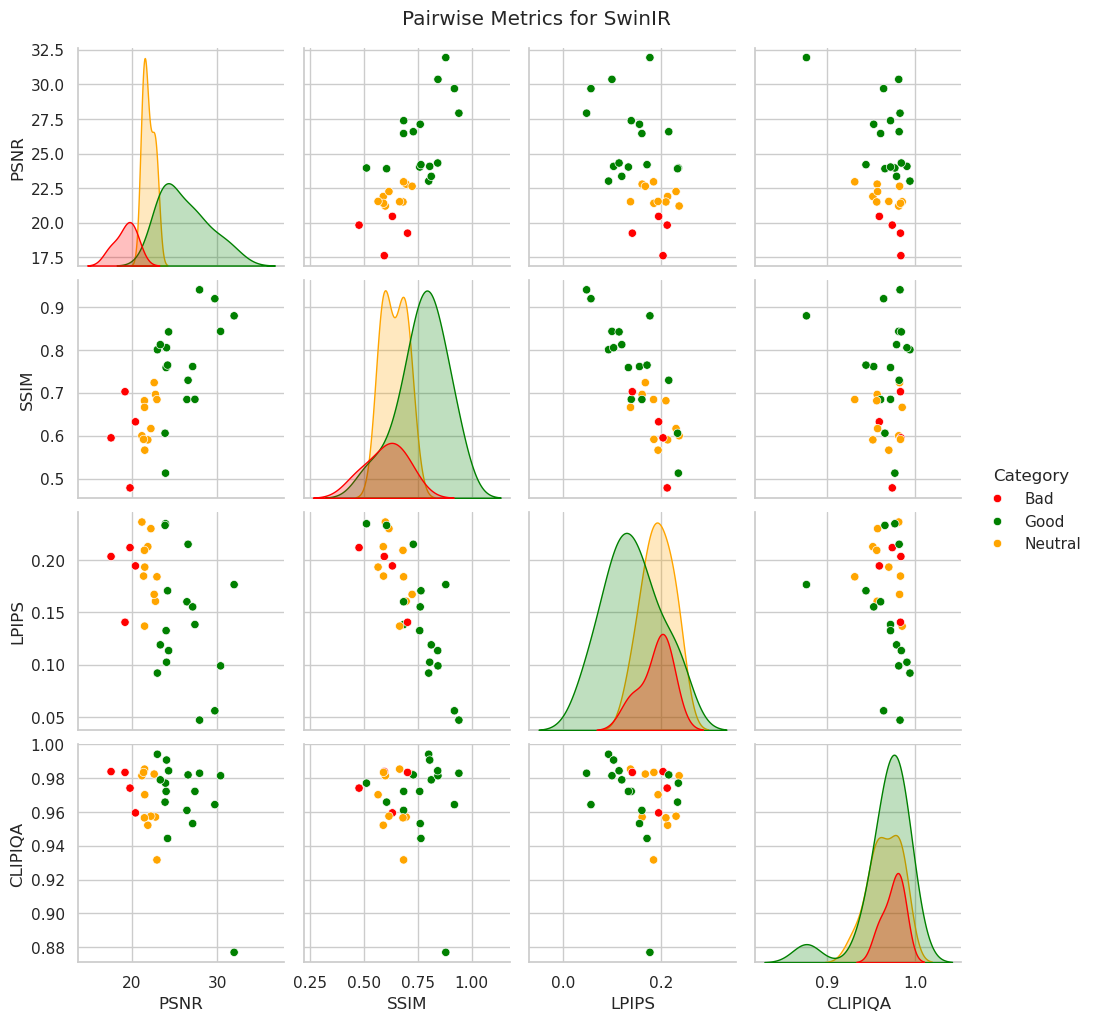

Pairwise metrics plot for SwinIR saved to visualizations/SwinIR_pairwise_metrics.png


In [12]:
def plot_pairwise_metrics(df, output_path="visualizations"):
    """
    Plot pairwise relationships between metrics for each model.
    """
    os.makedirs(output_path, exist_ok=True)
    
    metrics = ['PSNR', 'SSIM', 'LPIPS', 'CLIPIQA']
    
    for model in df['Model'].unique():
        model_df = df[df['Model'] == model]
        sns.pairplot(model_df, vars=metrics, hue='Category', palette={'Good':'green', 'Neutral':'orange', 'Bad':'red'})
        plt.suptitle(f'Pairwise Metrics for {model}', y=1.02)
        pairplot_path = os.path.join(output_path, f'{model}_pairwise_metrics.png')
        plt.savefig(pairplot_path)
        plt.show()
        print(f"Pairwise metrics plot for {model} saved to {pairplot_path}")

# After other visualizations
plot_pairwise_metrics(df)


/tmp/ipykernel_133382/1742190109.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Model"])


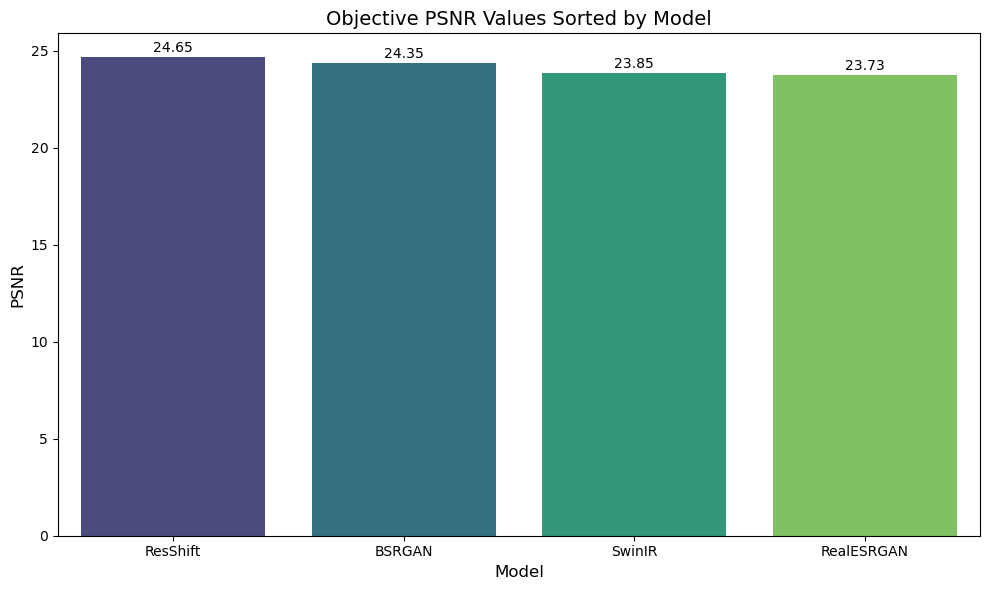

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame
data = {
    "Model": ["BSRGAN", "RealESRGAN", "ResShift", "SwinIR"],
    "PSNR": [24.354329, 23.734273, 24.652847, 23.853267],
    "SSIM": [0.703160, 0.696548, 0.723451, 0.705486],
    "LPIPS": [0.172492, 0.168849, 0.136435, 0.163606],
    "CLIPIQA": [0.976758, 0.971777, 0.986149, 0.968001],
}
df = pd.DataFrame(data)

# Sort by PSNR in descending order
df_sorted = df.sort_values(by="PSNR", ascending=False)

# Plot PSNR values
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Model"])
plt.title("Objective PSNR Values Sorted by Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("PSNR", fontsize=12)

# Add PSNR values on top of the bars
for i, value in enumerate(df_sorted["PSNR"]):
    ax.text(i, value + 0.1, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_133382/3374696331.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Method", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Method"])


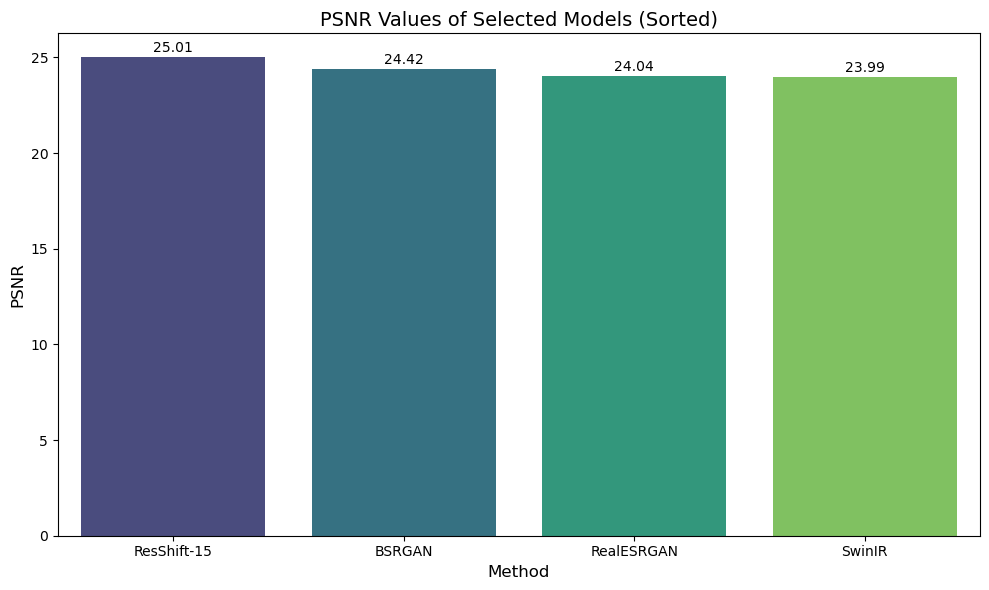

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the selected models
data = {
    "Method": ["BSRGAN", "SwinIR", "RealESRGAN", "ResShift-15"],
    "PSNR": [24.42, 23.99, 24.04, 25.01]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by PSNR in descending order
df_sorted = df.sort_values(by="PSNR", ascending=False)

# Plot a sorted bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Method", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Method"])
plt.title("PSNR Values of Selected Models (Sorted)", fontsize=14)
plt.xlabel("Method", fontsize=12)
plt.ylabel("PSNR", fontsize=12)

# Add PSNR values on top of the bars
for i, value in enumerate(df_sorted["PSNR"]):
    ax.text(i, value + 0.1, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_133382/648183146.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Method", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Method"])


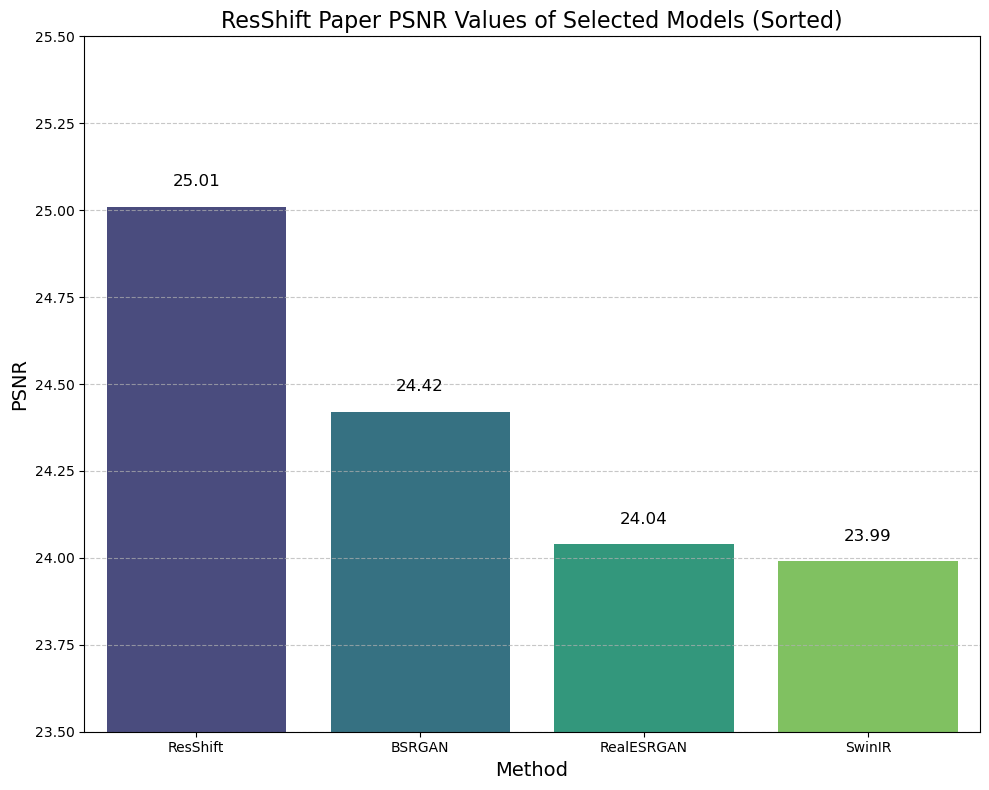

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the selected models
data = {
    "Method": ["BSRGAN", "SwinIR", "RealESRGAN", "ResShift"],
    "PSNR": [24.42, 23.99, 24.04, 25.01]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by PSNR in descending order
df_sorted = df.sort_values(by="PSNR", ascending=False)

# Plot a sorted bar chart with adjustments for better clarity
plt.figure(figsize=(10, 8))  # Increase height for better clarity
ax = sns.barplot(x="Method", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Method"])
plt.title("ResShift Paper PSNR Values of Selected Models (Sorted)", fontsize=16)
plt.xlabel("Method", fontsize=14)
plt.ylabel("PSNR", fontsize=14)

# Set a narrower y-axis range to highlight differences
plt.ylim(23.5, 25.5)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add PSNR values on top of the bars
for i, value in enumerate(df_sorted["PSNR"]):
    ax.text(i, value + 0.05, f"{value:.2f}", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipykernel_133382/134028903.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Model"])


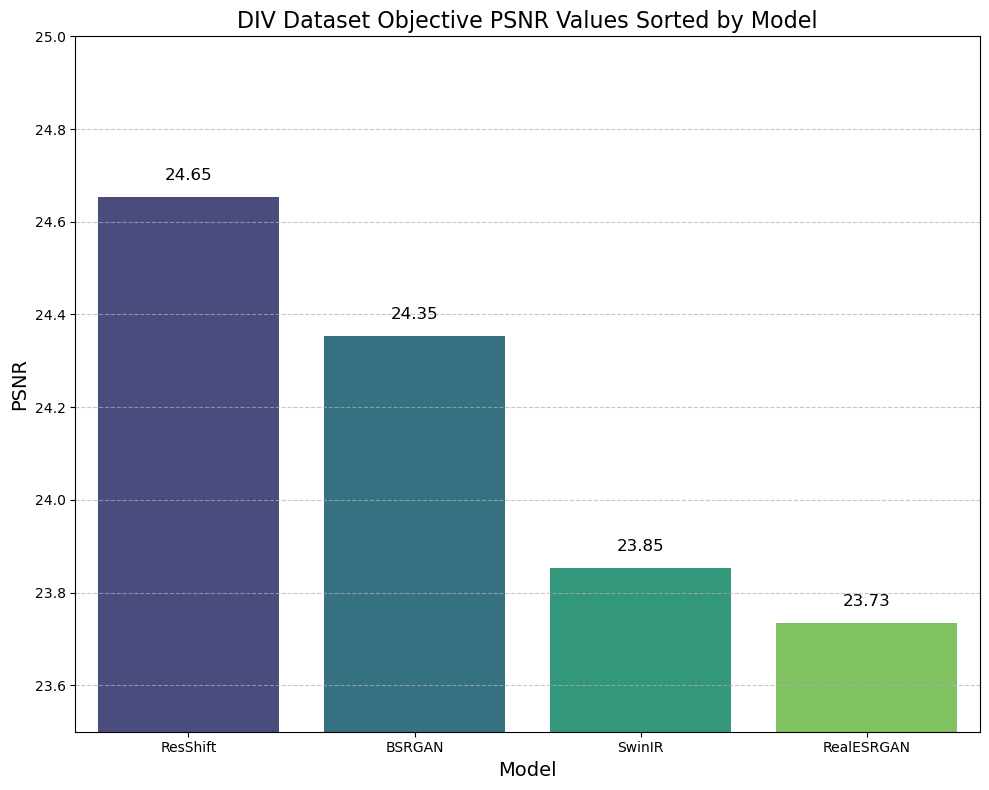

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame
data = {
    "Model": ["BSRGAN", "RealESRGAN", "ResShift", "SwinIR"],
    "PSNR": [24.354329, 23.734273, 24.652847, 23.853267],
    "SSIM": [0.703160, 0.696548, 0.723451, 0.705486],
    "LPIPS": [0.172492, 0.168849, 0.136435, 0.163606],
    "CLIPIQA": [0.976758, 0.971777, 0.986149, 0.968001],
}
df = pd.DataFrame(data)

# Sort by PSNR in descending order
df_sorted = df.sort_values(by="PSNR", ascending=False)

# Plot PSNR values
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Model", y="PSNR", data=df_sorted, palette="viridis", order=df_sorted["Model"])
plt.title("DIV Dataset Objective PSNR Values Sorted by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("PSNR", fontsize=14)

# Set a narrower y-axis range for better visualization
plt.ylim(23.5, 25.0)

# Add grid lines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add PSNR values on top of the bars
for i, value in enumerate(df_sorted["PSNR"]):
    ax.text(i, value + 0.03, f"{value:.2f}", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()
